In [13]:
import pandas as pd
from pandas import DataFrame
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import os
import re
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation


from typing import List

In [14]:
import plotly.io as pio

pio.renderers.default = 'browser'

In [15]:
files = os.listdir('pops3')

files_data = [file for file in files if re.search(r'Data', file)]

files_index = [file for file in files if re.search(r'Ids', file)]

# Ordena arquivos por timestep (numero pós o "t")
files_data = sorted(files_data, key=lambda x: int(x.split('t')[1].split()[0]))
files_index = sorted(files_index, key=lambda x: int(x.split('t')[1].split()[0]))

In [16]:
teste = pd.read_csv(f'pops3/{files_index[0]}', sep='\t', header=None, )
teste.columns = ['ancestral', 'id']
teste

,ancestral,id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1995,0,1996
1996,0,1997
1997,0,1998
1998,0,1999


In [17]:
def plot_tsne(data: DataFrame, timestep: int):
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
    data_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])

    # Faz o plot junto
    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(12, 6))

    species = df['species'] if 'species' in df.columns else None

    scatter = ax.scatter(df_tsne['x'], df_tsne['y'], c=species, cmap='viridis', label=species)
    
    ax.set_title(f'TSNE timestep {timestep}')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    
    if species is not None:
        legend1 = ax.legend(*scatter.legend_elements(), title="Species")
        ax.add_artist(legend1)
    
    plt.show()

    fig = px.scatter(df_tsne, x='x', y='y', title=f'TSNE timestep {timestep}', labels={'x': 'TSNE 1', 'y': 'TSNE 2'}, color=species)
    fig.show()


In [18]:
def agroup_species(data: DataFrame):
    dbscan = DBSCAN(eps=50, min_samples=1, n_jobs=-1)

    # agrupar por espécie
    if 'species' not in data.columns:
        data['species'] = dbscan.fit_predict(data)

    else:
        for i in data['species'].unique():
            group = data.loc[data['species'] == i]
            group = group.drop(columns=['species'])
            species = dbscan.fit_predict(group)
            
            data.loc[data['species'] == i, 'species'] = species
    
    return data

df1 = pd.read_csv(f'pops3/{files_data[90]}', sep='\t', header=None, )
df1.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

df2 = pd.read_csv(f'pops3/{files_data[300]}', sep='\t', header=None, )
df2.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

df1 = agroup_species(df1)
df2 = agroup_species(df2)


MovieWriter imagemagick unavailable; using Pillow instead.


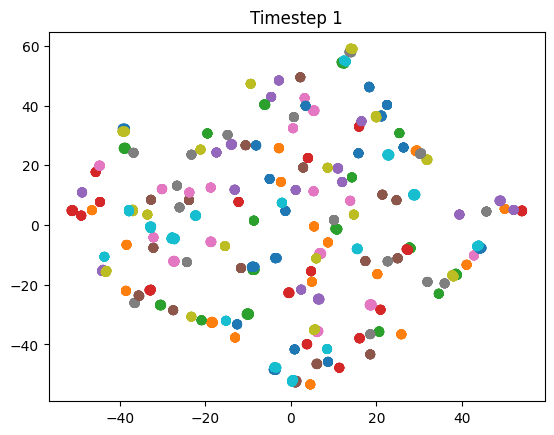

In [19]:


def animate_clusters(data_per_timestep, save_as="clusters_animation.gif"):
    fig, ax = plt.subplots()
    
    def update_plot(timestep):
        ax.clear()

        species = data_per_timestep[timestep]['species']
        
        # Executa o TSNE para o timestep atual
        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(data_per_timestep[timestep].drop(columns=['species']))

        # Scatter plot
        ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=species, cmap='tab10')
        ax.set_title(f'Timestep {timestep}')
    
    # Configura a animação
    ani = animation.FuncAnimation(fig, update_plot, frames=len(data_per_timestep), repeat=True)
    
    # Salvar como GIF
    ani.save(save_as, writer='imagemagick', fps=2)  # Pode salvar como mp4 também, trocando writer
    plt.show()

# Exemplo de uso
animate_clusters([df1, df2])

In [20]:
def plot_tsne_animated(data_per_timestep: List[DataFrame]):
    frames = []

    for timestep, data in enumerate(data_per_timestep):
        # Executa o TSNE para o timestep atual
        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(data.drop(columns=['species']))

        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        df_tsne['species'] = data['species']

        # Cria o frame para o timestep atual
        frame = px.scatter(df_tsne, x='x', y='y', color='species', title=f'TSNE Timestep {timestep}')
        frames.append(frame)

    # Cria uma animação
    fig = px.scatter(df_tsne, x='x', y='y', color='species', title='Evolução dos Agrupamentos no Tempo',
                     animation_frame=range(len(data_per_timestep)),
                     labels={'x': 'TSNE 1', 'y': 'TSNE 2'})
    
    fig.show()


In [21]:
np.unique([1, 1, 1])

array([1])

In [22]:
class Clusterizer:
    def __init__(self):
        self.files_data = []
        self.files_index = []
        self.current_df = None
        self.current_df_indexes = None
        self.dfs_per_timestep = []
        self.idx_per_timestep = []
        self.species_len = 0

    def get_files(self):
        files = os.listdir('pops3')

        files_data = [file for file in files if re.search(r'Data', file)]
        files_index = [file for file in files if re.search(r'Ids', file)]

        # Ordena arquivos por timestep (numero pós o "t")
        self.files_data = sorted(files_data, key=lambda x: int(x.split('t')[1].split()[0]))
        self.files_index = sorted(files_index, key=lambda x: int(x.split('t')[1].split()[0]))

    def _load_data(self, timestep: int):
        self.current_df = pd.read_csv(f'pops3/{self.files_data[timestep]}', sep='\t', header=None)
        self.current_df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

        self.current_df_indexes = pd.read_csv(f'pops3/{self.files_index[timestep]}', sep='\t', header=None)
        self.current_df_indexes.columns = ['ancestral', 'id']

        self.current_df['id'] = self.current_df_indexes['id']
    
    def _agroup_species(self, data: DataFrame):
        dbscan = DBSCAN(eps=50, min_samples=1, n_jobs=-1)

        last_df = self.dfs_per_timestep[-1] if self.dfs_per_timestep != [] else None

        if last_df is not None:
            data = pd.merge(data, last_df[['id', 'species']], on='id', how='left')
            data['species'] = data['species'].fillna(-1)
        else:
            data['species'] = -1

        # agrupar por espécie
        for i in data['species'].unique():
            group = data.loc[data['species'] == i]
            group = group.drop(columns=['species'])
            species = np.array(dbscan.fit_predict(group))
            species = species + self.species_len

            self.species_len += len(np.unique(species))

            data.loc[data['species'] == i, 'species'] = species
    
        # self.current_df_indexes['species'] = data['species']
        
        return data

    def parse_timesteps(self):
        for i in range(len(self.files_data)):
            print(f'Parsing timestep {i}')

            self._load_data(i)
            self.current_df = self._agroup_species(self.current_df)
            self.dfs_per_timestep.append(self.current_df)

    def animate_clusters(self, save_as="clusters_animation.gif"):
        fig, ax = plt.subplots()
        
        def update_plot(timestep):
            ax.clear()

            species = self.dfs_per_timestep[timestep]['species']
            
            # Executa o TSNE para o timestep atual
            tsne = TSNE(n_components=2, random_state=42)
            data_tsne = tsne.fit_transform(self.dfs_per_timestep[timestep].drop(columns=['species', 'id']))

            # Scatter plot
            ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=species, cmap='tab10')
            ax.set_title(f'Timestep {timestep}')
        
        # Configura a animação
        ani = animation.FuncAnimation(fig, update_plot, frames=len(self.dfs_per_timestep), repeat=True)
        
        # Salvar como GIF
        ani.save(save_as, writer='imagemagick', fps=2)  # Pode salvar como mp4 também, trocando writer
        plt.show()


Parsing timestep 0
Parsing timestep 1
Parsing timestep 2
Parsing timestep 3
Parsing timestep 4
Parsing timestep 5
Parsing timestep 6
Parsing timestep 7
Parsing timestep 8
Parsing timestep 9
Parsing timestep 10
Parsing timestep 11
Parsing timestep 12
Parsing timestep 13
Parsing timestep 14
Parsing timestep 15
Parsing timestep 16
Parsing timestep 17
Parsing timestep 18
Parsing timestep 19
Parsing timestep 20
Parsing timestep 21
Parsing timestep 22
Parsing timestep 23
Parsing timestep 24
Parsing timestep 25
Parsing timestep 26
Parsing timestep 27
Parsing timestep 28
Parsing timestep 29
Parsing timestep 30
Parsing timestep 31
Parsing timestep 32
Parsing timestep 33
Parsing timestep 34
Parsing timestep 35
Parsing timestep 36
Parsing timestep 37
Parsing timestep 38
Parsing timestep 39
Parsing timestep 40
Parsing timestep 41
Parsing timestep 42
Parsing timestep 43
Parsing timestep 44
Parsing timestep 45
Parsing timestep 46
Parsing timestep 47
Parsing timestep 48
Parsing timestep 49
Parsing ti

MovieWriter imagemagick unavailable; using Pillow instead.


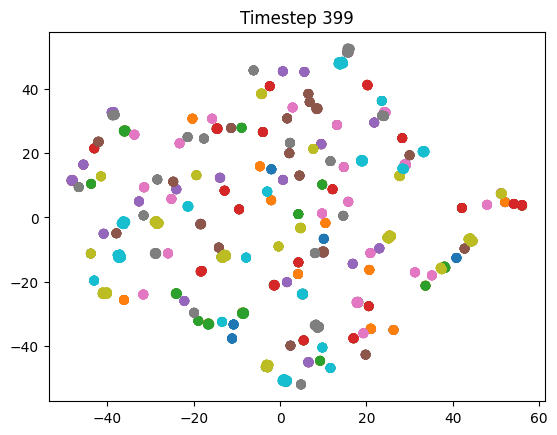

In [23]:
clusterizer = Clusterizer()
clusterizer.get_files()
clusterizer.parse_timesteps()
clusterizer.animate_clusters()
